In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import wf_psf

import wf_psf.SimPSFToolkit as SimPSFToolkit
import wf_psf.utils as wf_utils
import wf_psf.tf_psf_field as tf_psf_field

# Plot style & colormap

import matplotlib as mpl
import matplotlib.ticker as mtick
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import ImageGrid

from IPython.display import display, HTML

# Tables in python notebooks
from tabulate import tabulate

# Interactive plots
import plotly
import plotly.graph_objects as go
import plotly.io as pio   
pio.kaleido.scope.mathjax = None

# Pre-defined colormap
top = mpl.cm.get_cmap('Oranges_r', 128)
bottom = mpl.cm.get_cmap('Blues', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')


plot_style = {
    'mpl_toolkits.legacy_colorbar': False,
    'axes.formatter.use_mathtext': True,
    'text.usetex': False,
}
mpl.rcParams.update(plot_style)

plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels

# Model Parameters

In [2]:
# Parameters
d_max = 2
max_order = 45
x_lims = [0, 1e3]
y_lims = [0, 1e3]
grid_points = [4, 4]
n_bins = 20
auto_init = True
verbose = True

oversampling_rate = 3.
output_Q = 3.

max_wfe_rms = 0.1
output_dim = 32
LP_filter_length = 2
euclid_obsc = True

pupil_diameter = 256

# Super resolved PSFs
super_out_Q = 1
super_out_res = 64

max_bins = 350

# Load Star SEDs

In [3]:
# SED folder path
SED_path = './../../../wf-psf/data/SEDs/save_SEDs/'
# Output saving path
output_folder = './../outputs/output-SEDs/'
plots_folder = './../outputs/plots/'

stellar_SEDs = np.load(SED_path + 'SEDs.npy', allow_pickle=True)
stellar_lambdas = np.load(SED_path + 'lambdas.npy', allow_pickle=True)
SED_name = ['O5V', 'B0V', 'B5-7V', 'A0V', 'A5V', 'F0V', 'F5V', 'G0V', 'G5V', 'K0V', 'K5V', 'M0V', 'M5V']
n_SEDs = len(SED_name)
# Create packed SEDs and lambdas lists
SED_list = []
for it in range(n_SEDs):
    concat_SED_wv = np.concatenate((stellar_lambdas.reshape(-1,1),
                                    stellar_SEDs[it,:].reshape(-1,1)), axis=1)
    SED_list.append(concat_SED_wv)
SED_np = np.array(SED_list)

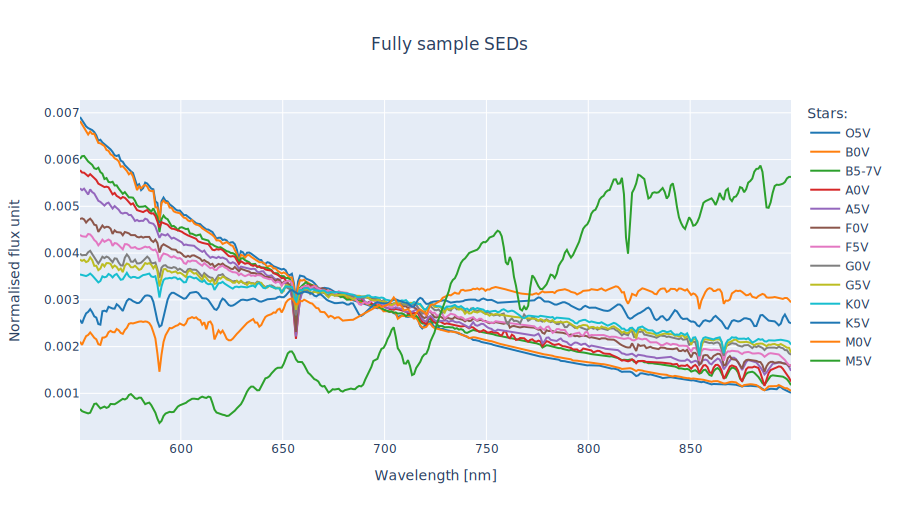

In [30]:
colors = plotly.colors.DEFAULT_PLOTLY_COLORS

fig = go.Figure()

for star_id in range(len(SED_name)):
    fig.add_trace(go.Scatter(
        x=stellar_lambdas,
        y=stellar_SEDs[star_id,:],
        name=SED_name[star_id],
        line=dict(color=colors[np.mod(star_id,10)])
    ))

fig.update_xaxes(title_text='Wavelength [nm]')
fig.update_yaxes(title_text="Normalised flux unit")
fig.update_layout(legend_title_text='Stars:', title={'text':'Fully sample SEDs', 'x':0.5}, width=900, height=520)

#fig.write_image('../outputs/plots/fully_sample_seds.pdf', engine='kaleido')
# Remove <'svg'> to run cell as an interactive plot
fig.show('svg')

### Generate Zernikes and Initialize PSF generator

In [5]:
# Generate Zernike maps
zernikes = wf_psf.utils.zernike_generator(n_zernikes=max_order, wfe_dim=pupil_diameter)

# Initialize PSF simulator
sim_PSF_toolkit = wf_psf.SimPSFToolkit(
    zernikes, max_order=max_order, max_wfe_rms=max_wfe_rms, oversampling_rate=oversampling_rate,
    output_Q=super_out_Q, output_dim=super_out_res, pupil_diameter=pupil_diameter, euclid_obsc=euclid_obsc,
    LP_filter_length=LP_filter_length)

# Initialize PSF field
gen_poly_fieldPSF = wf_psf.GenPolyFieldPSF(sim_PSF_toolkit, d_max=d_max,
                                    grid_points=grid_points, max_order=max_order,
                                    x_lims=x_lims, y_lims=y_lims, n_bins=max_bins,
                                    lim_max_wfe_rms=max_wfe_rms, verbose=verbose)

In [6]:
# Load C_poly
C_poly = np.load('../outputs/ground_truth/C_poly.npy', allow_pickle=True)
gen_poly_fieldPSF.C_poly = C_poly

In [7]:
# Choose the location (randomly) and save it
# pos_np = np.random.rand(1, 2)
# pos_np[:,0] = pos_np[:,0]*(x_lims[1] - x_lims[0]) + x_lims[0]
# pos_np[:,1] = pos_np[:,1]*(y_lims[1] - y_lims[0]) + y_lims[0]
# np.save('../outputs/ground_truth/pos.npy',pos_np, allow_pickle=True)

# Load saved position
pos_np = np.load('../outputs/ground_truth/pos.npy', allow_pickle=True)

# Generate/load Ground Truth PSFs

In [8]:
# # Generate all the polychromatic PSFs
# gt_poly_psf_list = []
# zernike_coef_list = []

# # Generate polychromatic PSF at 3x Euclid resolution
# for it in range(n_SEDs):
#     _psf, _zernike, _ = gen_poly_fieldPSF.get_poly_PSF(xv_flat=pos_np[0, 0],
#                                                         yv_flat=pos_np[0, 1],
#                                                         SED=SED_list[it])
#     gt_poly_psf_list.append(_psf)
#     zernike_coef_list.append(_zernike)  

# # Generate numpy arrays from the lists
# gt_poly_psf_np = np.array(gt_poly_psf_list)
# zernike_coef_np = np.array(zernike_coef_list)

# Save ground truth data
# np.save('../outputs/ground_truth/gt_poly_psf.npy',gt_poly_psf_np,allow_pickle=True)
# np.save('../outputs/ground_truth/gt_zernike_coef.npy',zernike_coef_np,allow_pickle=True)
# np.save('../outputs/ground_truth/C_poly.npy',gen_poly_fieldPSF.C_poly,allow_pickle=True)

In [9]:
# Load data
gt_poly_psf_np = np.load('../outputs/ground_truth/gt_poly_psf.npy', allow_pickle=True)
zernike_coef_np = np.load('../outputs/ground_truth/gt_zernike_coef.npy', allow_pickle=True)


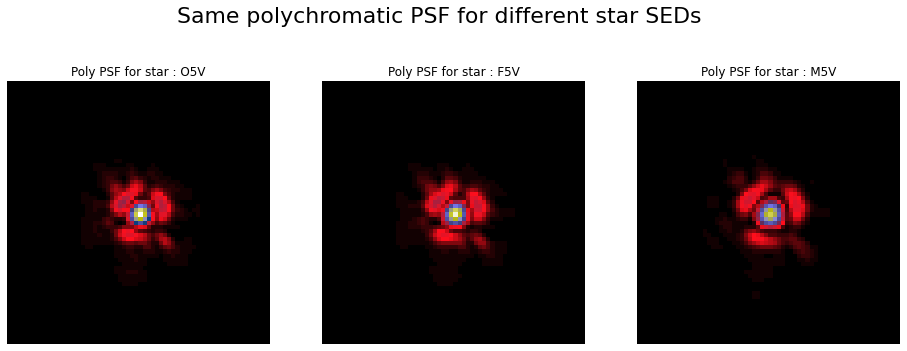

In [10]:
display_stars = [0, 6, 12]
vmax = np.max(np.abs(gt_poly_psf_np))

#fig, ax = plt.subplots(3, 5, figsize=(20,11), facecolor='white')
fig, ax = plt.subplots(1, 3, figsize=(16,6), facecolor='white')
fig.suptitle('Same polychromatic PSF for different star SEDs', fontsize=22)

# for itr, (axis,star_name) in enumerate(zip(ax.ravel(),SED_name)):
#     im = axis.imshow(gt_poly_psf_np[itr,:,:],cmap='gist_stern', vmax=vmax, vmin=0)
#     axis.set_title('Poly PSF for star : '+ star_name)
#     axis.set_xticks([])

for itr, star_id in enumerate(display_stars):
    im = ax[itr].imshow(gt_poly_psf_np[star_id,:,:],cmap='gist_stern', vmax=vmax, vmin=0)
    ax[itr].set_title('Poly PSF for star : '+ SED_name[star_id])
    ax[itr].set_xticks([])


for axis in ax.ravel():
    axis.axis('off')

#plt.savefig('../outputs/plots/PSF_for_each_SED.pdf')
plt.show()

In [11]:
'''
for psf_, star_name in zip(gt_poly_psf_list,SED_name):
    fig = plt.figure(figsize=(5,5), facecolor='white')
    plt.imshow(psf_,cmap='gist_stern', vmax=vmax, vmin=0)
    plt.title('Poly PSF for star : '+ star_name)
    plt.savefig(plots_folder+'poly_psf_'+star_name+'.jpg')
    plt.close(fig)

button_str = '<input type="radio" name="images" onclick="show{}();">{}</input>\n'
image_str = '<div id="image{}">\n  <img src="./../outputs/plots/poly_psf_{}.jpg"\n  width="300"\n  height="300" >\n</div>\n'
display_str = '  document.getElementById(\'image{}\').style.display =\'{}\';\n'

html = 'Select an Image:\n'
for it,star_name in enumerate(SED_name):
    html = html + button_str.format(str(it+1), star_name)
for it,star_name in enumerate(SED_name):
    html = html + image_str.format(str(it+1), star_name)
html = html + '<script>\n'

for it,star_name in enumerate(SED_name):
    html = html + 'function show{}(){{\n'.format(str(it+1))
    for it_, star_name_ in enumerate(SED_name):
        if it_ == it:
            status = 'block'
        else:
            status = 'none'
        html = html + display_str.format(it_+1, status)
    html = html + '}\n'

html = html + 'show1()\n</script>'

display(HTML(html))
'''

'\nfor psf_, star_name in zip(gt_poly_psf_list,SED_name):\n    fig = plt.figure(figsize=(5,5), facecolor=\'white\')\n    plt.imshow(psf_,cmap=\'gist_stern\', vmax=vmax, vmin=0)\n    plt.title(\'Poly PSF for star : \'+ star_name)\n    plt.savefig(plots_folder+\'poly_psf_\'+star_name+\'.jpg\')\n    plt.close(fig)\n\nbutton_str = \'<input type="radio" name="images" onclick="show{}();">{}</input>\n\'\nimage_str = \'<div id="image{}">\n  <img src="./../outputs/plots/poly_psf_{}.jpg"\n  width="300"\n  height="300" >\n</div>\n\'\ndisplay_str = \'  document.getElementById(\'image{}\').style.display =\'{}\';\n\'\n\nhtml = \'Select an Image:\n\'\nfor it,star_name in enumerate(SED_name):\n    html = html + button_str.format(str(it+1), star_name)\nfor it,star_name in enumerate(SED_name):\n    html = html + image_str.format(str(it+1), star_name)\nhtml = html + \'<script>\n\'\n\nfor it,star_name in enumerate(SED_name):\n    html = html + \'function show{}(){{\n\'.format(str(it+1))\n    for it_, star

In [12]:
'''
example_html = """
    Select an Image:
    <input type="radio" name="images" onclick="show1();" checked>A0V</input>
    <input type="radio" name="images" onclick="show2();">A5V</input>
    <input type="radio" name="images" onclick="show3();">B0V</input>

    <div id="image1">
      <img src="./../outputs/plots/poly_psf_A0V.jpg">
    </div>
    <div id="image2">
      <img src="./../outputs/plots/poly_psf_A5V.jpg">
    </div>
    <div id="image3">
      <img src="./../outputs/plots/poly_psf_B0V.jpg">
    </div>
  
    <script>
    function show1(){
      document.getElementById('image1').style.display ='block';
      document.getElementById('image2').style.display ='none';
      document.getElementById('image3').style.display ='none';
    }
    function show2(){
      document.getElementById('image2').style.display ='block';
      document.getElementById('image1').style.display ='none';
      document.getElementById('image3').style.display ='none';
    }
    function show3(){
      document.getElementById('image3').style.display ='block';
      document.getElementById('image1').style.display ='none';
      document.getElementById('image2').style.display ='none';
    }
    show1()
    </script>
"""

'''

'\nexample_html = """\n    Select an Image:\n    <input type="radio" name="images" onclick="show1();" checked>A0V</input>\n    <input type="radio" name="images" onclick="show2();">A5V</input>\n    <input type="radio" name="images" onclick="show3();">B0V</input>\n\n    <div id="image1">\n      <img src="./../outputs/plots/poly_psf_A0V.jpg">\n    </div>\n    <div id="image2">\n      <img src="./../outputs/plots/poly_psf_A5V.jpg">\n    </div>\n    <div id="image3">\n      <img src="./../outputs/plots/poly_psf_B0V.jpg">\n    </div>\n  \n    <script>\n    function show1(){\n      document.getElementById(\'image1\').style.display =\'block\';\n      document.getElementById(\'image2\').style.display =\'none\';\n      document.getElementById(\'image3\').style.display =\'none\';\n    }\n    function show2(){\n      document.getElementById(\'image2\').style.display =\'block\';\n      document.getElementById(\'image1\').style.display =\'none\';\n      document.getElementById(\'image3\').style.disp

# Generate low SED resolution PSFs (binned SEDs)

In [13]:
generate_binned_PSF = False

In [14]:
n_bins_list = [4,8,16,32,64]
gen_poly_fieldPSF.sim_psf_toolkit.SED_sigma = 0

if generate_binned_PSF:
    # Generate all the polychromatic PSFs
    poly_psf_list = []

    for n_bins in n_bins_list:

        # Set right number of bins
        gen_poly_fieldPSF.n_bins = n_bins

        psf_list = []
        # Generate polychromatic PSF at 3x Euclid resolution
        for it in range(n_SEDs):
            _psf, _, _ = gen_poly_fieldPSF.get_poly_PSF(xv_flat=pos_np[0, 0],
                                                                yv_flat=pos_np[0, 1],
                                                                SED=SED_list[it])
            psf_list.append(_psf)

        poly_psf_list.append(psf_list)

    np.save('../outputs/predictions/binned_poly_psf.npy',np.array(poly_psf_list),allow_pickle=True)

In [15]:
# Load binned PSFs
binned_poly_psf =  np.load('../outputs/predictions/binned_poly_psf.npy',allow_pickle=True)

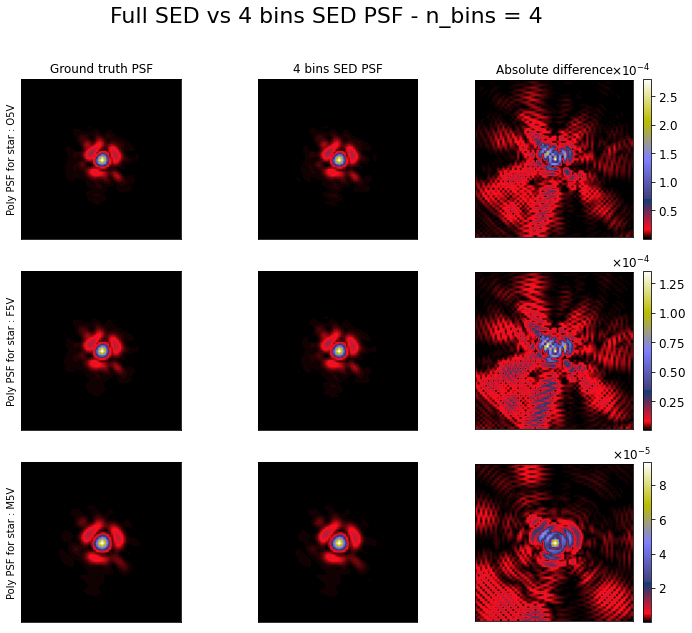

In [16]:
display_stars = [0, 6, 12]

fig, ax = plt.subplots(3, 3, figsize=(12,10), facecolor='white')
fig.suptitle('Full SED vs 4 bins SED PSF - n_bins = 4', fontsize=22)

for itr, star_id in enumerate(display_stars):
    im = ax[itr][0].imshow(gt_poly_psf_np[star_id,:,:],cmap='gist_stern')
    ax[itr][0].set_ylabel('Poly PSF for star : '+ SED_name[star_id])
    if itr == 0:
        ax[itr][0].set_title('Ground truth PSF')
    ax[itr][0].set_xticks([])
    ax[itr][0].set_yticks([])

    im = ax[itr][1].imshow(binned_poly_psf[0,star_id,:,:],cmap='gist_stern')
    if itr == 0:
        ax[itr][1].set_title('4 bins SED PSF')
    ax[itr][1].set_xticks([])
    ax[itr][1].set_yticks([])

    im = ax[itr][2].imshow(np.abs(gt_poly_psf_np[star_id,:,:]-binned_poly_psf[0,star_id,:,:]),cmap='gist_stern')
    if itr == 0:
        ax[itr][2].set_title('Absolute difference')
    ax[itr][2].set_xticks([])
    ax[itr][2].set_yticks([])
    cbar = plt.colorbar(im, ax=ax[itr][2])
    cbar.formatter.set_powerlimits((0, 0))

#plt.savefig('../outputs/plots/PSF_for_each_SED.pdf')
plt.show()

In [17]:
def get_RMSE(psf1, psf2):
    residual = np.sqrt(np.mean((psf1 - psf2)**2, axis=(0,1)))
    gt_mean  = np.sqrt(np.mean(psf1**2, axis=(0,1)))
    return residual, 100. * (residual/gt_mean)

In [18]:
abs_rmse_mat_binning = np.zeros((len(n_bins_list), len(SED_name)))
rel_rmse_mat_binning = np.zeros((len(n_bins_list), len(SED_name)))

for n_bins in range(len(n_bins_list)):
    for star_id in range(len(SED_name)):
        abs_rmse_mat_binning[n_bins, star_id], rel_rmse_mat_binning[n_bins, star_id] = get_RMSE(gt_poly_psf_np[star_id,:,:], binned_poly_psf[n_bins,star_id,:,:])

In [19]:
table = (np.around(rel_rmse_mat_binning, decimals=2)).tolist()

table.insert(0,SED_name.copy())
table[0].insert(0,'n_bins')
for idx, n_bins in enumerate(n_bins_list):
    table[idx+1].insert(0, n_bins)
print('\t\t\t\tRelative PSF error [%]')
print(tabulate(table))


				Relative PSF error [%]
------  ----  ----  -----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----
n_bins  O5V   B0V   B5-7V  A0V   A5V   F0V   F5V   G0V   G5V   K0V   K5V   M0V   M5V
4       1.13  1.12  0.98   0.93  0.87  0.76  0.7   0.64  0.61  0.57  0.46  0.43  0.43
8       0.31  0.31  0.26   0.25  0.23  0.19  0.17  0.16  0.15  0.14  0.11  0.11  0.12
16      0.1   0.1   0.08   0.09  0.08  0.07  0.06  0.06  0.06  0.05  0.04  0.03  0.03
32      0.04  0.04  0.05   0.04  0.04  0.04  0.03  0.03  0.03  0.03  0.03  0.05  0.05
64      0.01  0.01  0.02   0.01  0.01  0.01  0.01  0.02  0.01  0.01  0.01  0.01  0.01
------  ----  ----  -----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----


# Generate noisy SED PSFs

In [36]:
generate_noisy_PSF = False

In [37]:
n_bins_list = [4,8,16,32,64]
sigma_list = [0.05, 0.02, 0.01, 0.005]

if generate_noisy_PSF:
    # Generate all the polychromatic PSFs
    noisy_poly_psf_list = []

    # Generate PSFs for each number of bins
    for n_bins in n_bins_list:
        # Sigma values for the current n_bins SED. Adapt noise to the expected bin value (1/n_bins)
        sigma_vec = np.array(sigma_list)/n_bins

        # Set right number of bins
        gen_poly_fieldPSF.n_bins = n_bins

        psf_list = []
        # Generate every noise level PSF for each star type

        for it in range(n_SEDs):
            noisy_psf_list = []
            # Iterate over each noise level
            
            for SED_sigma in sigma_vec:
                # Set noise std dev
                gen_poly_fieldPSF.sim_psf_toolkit.SED_sigma = SED_sigma
                # Generate PSF
                _psf, _, _ = gen_poly_fieldPSF.get_poly_PSF(xv_flat=pos_np[0, 0],
                                                                    yv_flat=pos_np[0, 1],
                                                                    SED=SED_list[it])
                noisy_psf_list.append(_psf)

            psf_list.append(noisy_psf_list)

        noisy_poly_psf_list.append(psf_list)

    # Convert to numpy and reorder axis so the noise sigma its the first axis (axis=0)
    noisy_poly_psf_np = np.moveaxis(np.array(noisy_poly_psf_list),2,0)
    np.save('../outputs/predictions/noisy_poly_psf.npy', noisy_poly_psf_np, allow_pickle=True)

In [38]:
noisy_poly_psf = np.load('../outputs/predictions/noisy_poly_psf.npy', allow_pickle=True)

### Noisy bins PSF vs binned PSF (just consider noise)

In [39]:
abs_rmse_mat_noisy = np.zeros((len(sigma_list), len(n_bins_list), len(SED_name)))
rel_rmse_mat_noisy = np.zeros((len(sigma_list), len(n_bins_list), len(SED_name)))

for itr, sigma in enumerate(sigma_list):

    for n_bins in range(len(n_bins_list)):
        for star_id in range(len(SED_name)):
            abs_rmse_mat_noisy[itr,n_bins, star_id], rel_rmse_mat_noisy[itr,n_bins, star_id] = get_RMSE(binned_poly_psf[n_bins,star_id,:,:], noisy_poly_psf[itr,n_bins,star_id,:,:])


    table = (np.around(rel_rmse_mat_noisy[itr,:,:], decimals=2)).tolist()

    table.insert(0,SED_name.copy())
    table[0].insert(0,'n_bins')
    for idx, n_bins in enumerate(n_bins_list):
        table[idx+1].insert(0, n_bins)
    print('\t\t\tRelative PSF error [%]  -  sigma = ', sigma)
    print(tabulate(table))
    print('\n\n')

			Relative PSF error [%]  -  sigma =  0.05
------  ----  ----  -----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----
n_bins  O5V   B0V   B5-7V  A0V   A5V   F0V   F5V   G0V   G5V   K0V   K5V   M0V   M5V
4       0.18  0.54  0.25   0.37  0.46  0.38  0.31  0.74  0.19  0.64  0.44  0.15  0.96
8       0.2   0.2   0.91   0.13  0.02  0.11  0.51  0.33  0.18  0.35  0.36  0.15  0.78
16      0.09  0.09  0.67   0.06  0.1   0.14  0.08  0.11  0.23  0.03  0.15  0.16  0.09
32      0.12  0.3   0.17   0.07  0.2   0.05  0.31  0.34  0.11  0.2   0.05  0.22  0.23
64      0.05  0.21  0.09   0.25  0.08  0.1   0.21  0.09  0.12  0.06  0.06  0.05  0.05
------  ----  ----  -----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----



			Relative PSF error [%]  -  sigma =  0.02
------  ----  ----  -----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----
n_bins  O5V   B0V   B5-7V  A0V   A5V   F0V   F5V   G0V   G5V   K0V   K5V   M0V   M5V
4       0.27  0.37  0.37   0.31  0.17  0.09  0.09  

### Noisy bins PSF vs ground truth (binning and noise degradations)

In [40]:
abs_rmse_mat_noisy_bins = np.zeros((len(sigma_list), len(n_bins_list), len(SED_name)))
rel_rmse_mat_noisy_bins = np.zeros((len(sigma_list), len(n_bins_list), len(SED_name)))

for itr, sigma in enumerate(sigma_list):

    for n_bins in range(len(n_bins_list)):
        for star_id in range(len(SED_name)):
            abs_rmse_mat_noisy_bins[itr,n_bins, star_id], rel_rmse_mat_noisy_bins[itr,n_bins, star_id] = get_RMSE(gt_poly_psf_np[star_id,:,:], noisy_poly_psf[itr,n_bins,star_id,:,:])


    table = (np.around(rel_rmse_mat_noisy_bins[itr,:,:], decimals=2)).tolist()

    table.insert(0,SED_name.copy())
    table[0].insert(0,'n_bins')
    for idx, n_bins in enumerate(n_bins_list):
        table[idx+1].insert(0, n_bins)
    print('\t\t\tRelative PSF error [%]  -  sigma = ', sigma)
    print(tabulate(table))
    print('\n\n')

			Relative PSF error [%]  -  sigma =  0.05
------  ----  ----  -----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----
n_bins  O5V   B0V   B5-7V  A0V   A5V   F0V   F5V   G0V   G5V   K0V   K5V   M0V   M5V
4       1.09  1.11  1.09   1.06  1.17  0.94  0.87  0.84  0.62  0.98  0.58  0.46  0.89
8       0.27  0.33  0.88   0.27  0.22  0.24  0.55  0.37  0.25  0.37  0.39  0.16  0.71
16      0.09  0.13  0.7    0.05  0.08  0.18  0.09  0.12  0.25  0.06  0.15  0.17  0.1
32      0.14  0.31  0.16   0.07  0.19  0.05  0.3   0.36  0.09  0.22  0.05  0.26  0.19
64      0.05  0.21  0.1    0.25  0.08  0.1   0.2   0.08  0.12  0.07  0.06  0.05  0.05
------  ----  ----  -----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----



			Relative PSF error [%]  -  sigma =  0.02
------  ----  ----  -----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----
n_bins  O5V   B0V   B5-7V  A0V   A5V   F0V   F5V   G0V   G5V   K0V   K5V   M0V   M5V
4       1.22  1.08  0.92   1.09  0.95  0.72  0.67  0

# Plot results

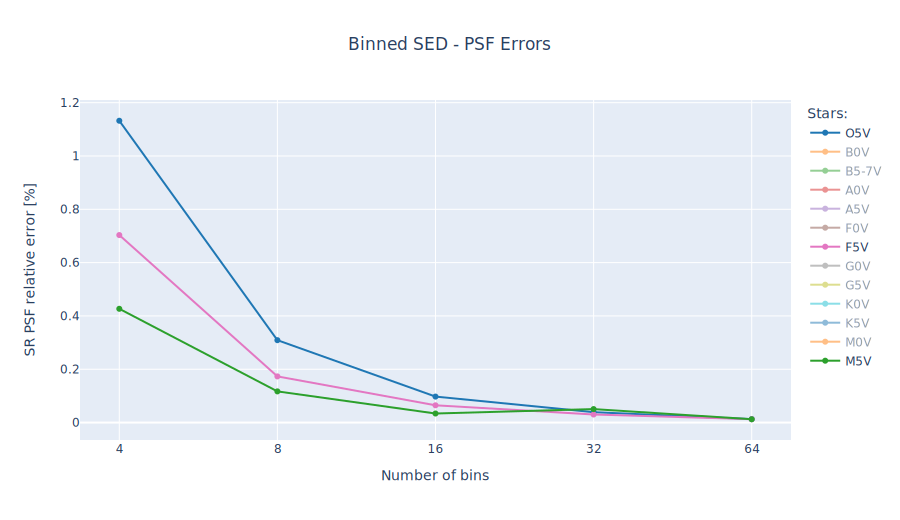

In [41]:
display_stars = [0,6,12]
colors = plotly.colors.DEFAULT_PLOTLY_COLORS

fig = go.Figure()

for star_id in range(len(SED_name)):
    fig.add_trace(go.Scatter(
        x=n_bins_list,
        y=rel_rmse_mat_binning[:,star_id],
        name=SED_name[star_id],
        visible=True if star_id in display_stars else 'legendonly',
        line=dict(color=colors[np.mod(star_id,10)])
    ))

fig.update_xaxes(tickvals=n_bins_list, title_text="Number of bins", type="log")
fig.update_yaxes(title_text="SR PSF relative error [%]")
fig.update_layout(legend_title_text='Stars:', title={'text':'Binned SED - PSF Errors', 'x':0.5}, width=900, height=520)

#fig.write_image('../outputs/plots/bins_errors.pdf', engine='kaleido')
# Remove <'svg'> to run cell as an interactive plot
fig.show('svg')

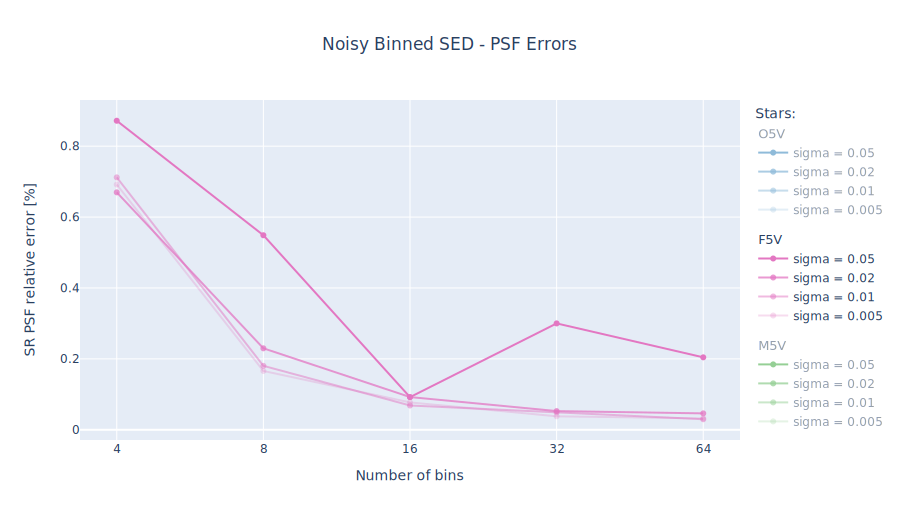

In [42]:
display_stars = [0,6,12]
oppacity_sigma_list = [1, 0.75, 0.5, 0.25]

colors = plotly.colors.DEFAULT_PLOTLY_COLORS

fig = go.Figure()

for idx, star_id in enumerate(display_stars):
    for sigma_id in range(len(sigma_list)):
        fig.add_trace(go.Scatter(
            legendgroup=SED_name[star_id],
            legendgrouptitle_text=SED_name[star_id],
            x=n_bins_list,
            y=rel_rmse_mat_noisy_bins[sigma_id,:,star_id],
            name='sigma = {}'.format(sigma_list[sigma_id]),
            visible=True if idx==1 else 'legendonly',
            line=dict(color='rgba'+colors[np.mod(star_id,10)][3:-1]+', {})'.format(oppacity_sigma_list[sigma_id]))
        ))

fig.update_xaxes(tickvals=n_bins_list, title_text="Number of bins", type="log")
fig.update_yaxes(title_text="SR PSF relative error [%]")
fig.update_layout(legend_title_text='Stars:', title={'text':'Noisy Binned SED - PSF Errors', 'x':0.5}, width=900, height=520)

#fig.write_image('../outputs/plots/noisy_bins_errors.pdf', engine='kaleido')
# Remove <'svg'> to run cell as an interactive plot
fig.show('svg')

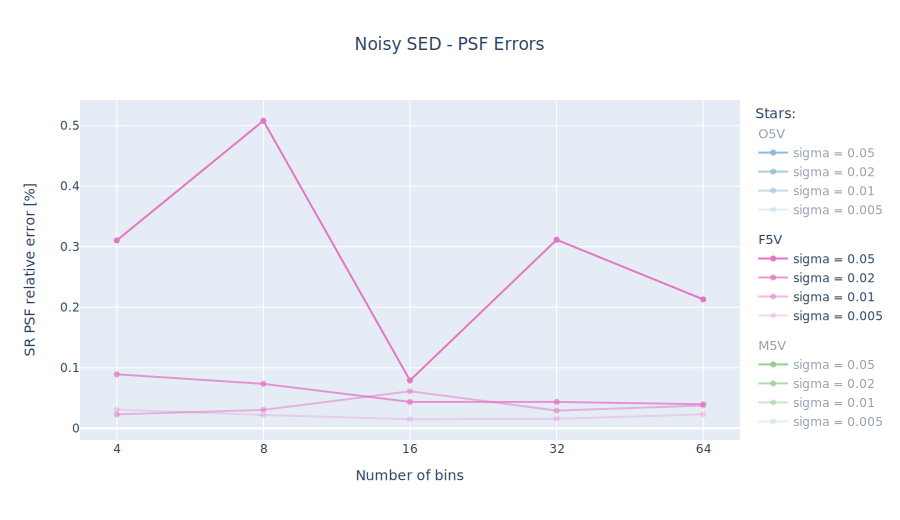

In [43]:
display_stars = [0,6,12]
oppacity_sigma_list = [1, 0.75, 0.5, 0.25]

colors = plotly.colors.DEFAULT_PLOTLY_COLORS

fig = go.Figure()

for idx, star_id in enumerate(display_stars):
    for sigma_id in range(len(sigma_list)):
        fig.add_trace(go.Scatter(
            legendgroup=SED_name[star_id],
            legendgrouptitle_text=SED_name[star_id],
            x=n_bins_list,
            y=rel_rmse_mat_noisy[sigma_id,:,star_id],
            name='sigma = {}'.format(sigma_list[sigma_id]),
            visible=True if idx==1 else 'legendonly',
            line=dict(color='rgba'+colors[np.mod(star_id,10)][3:-1]+', {})'.format(oppacity_sigma_list[sigma_id])),
        ))

fig.update_xaxes(tickvals=n_bins_list, title_text="Number of bins", type="log")
fig.update_yaxes(title_text="SR PSF relative error [%]")
fig.update_layout(legend_title_text='Stars:', title={'text':'Noisy SED - PSF Errors', 'x':0.5}, width=900, height=520)

#fig.write_image('../outputs/plots/noisy_errors.pdf', engine='kaleido')
# Remove <'svg'> to run cell as an interactive plot
fig.show('svg')

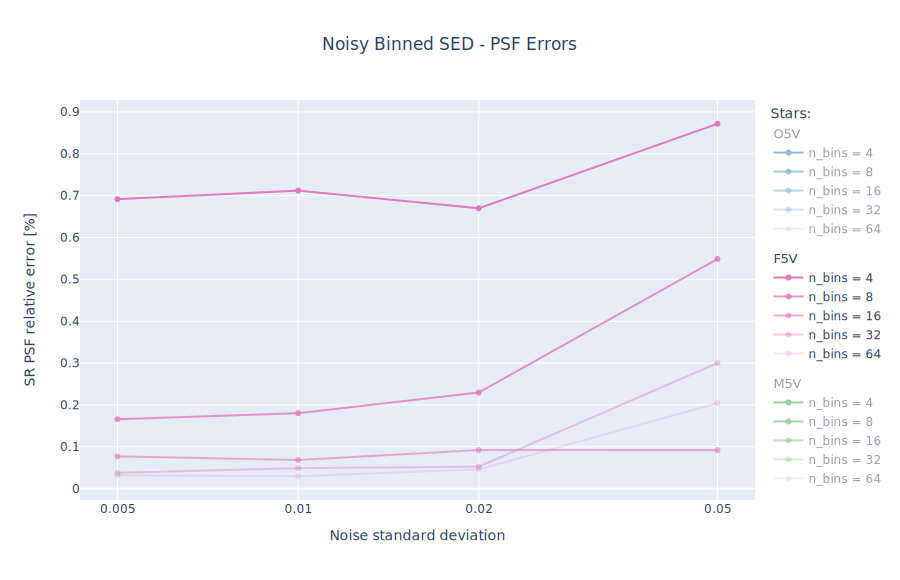

In [44]:
display_stars = [0,6,12]
oppacity_bins_list = [1, 0.8, 0.6, 0.4, 0.2]

colors = plotly.colors.DEFAULT_PLOTLY_COLORS

fig = go.Figure()

for idx, star_id in enumerate(display_stars):
    for bins_id in range(len(n_bins_list)):
        fig.add_trace(go.Scatter(
            legendgroup=SED_name[star_id],
            legendgrouptitle_text=SED_name[star_id],
            x=sigma_list,
            y=rel_rmse_mat_noisy_bins[:,bins_id,star_id],
            name='n_bins = {}'.format(n_bins_list[bins_id]),
            visible=True if idx==1 else 'legendonly',
            line=dict(color='rgba'+colors[np.mod(star_id,10)][3:-1]+', {})'.format(oppacity_bins_list[bins_id])),
        ))

fig.update_xaxes(tickvals=sigma_list, title_text="Noise standard deviation", type="log")
fig.update_yaxes(title_text="SR PSF relative error [%]")
fig.update_layout(legend_title_text='Stars:', title={'text':'Noisy Binned SED - PSF Errors', 'x':0.5}, width=900, height=580)

#fig.write_image('../outputs/plots/noisy_bins_errors_xsigma.pdf', engine='kaleido')
# Remove <'svg'> to run cell as an interactive plot
fig.show('svg')

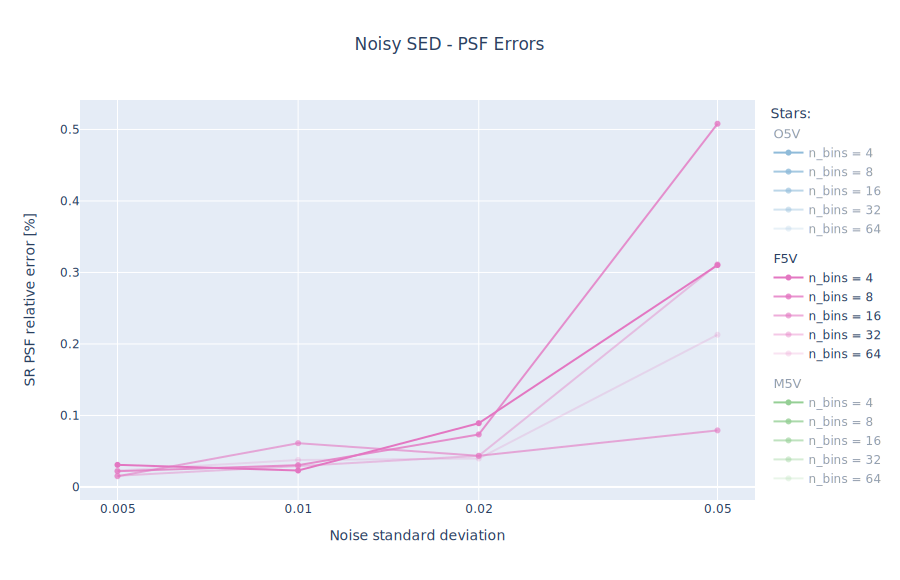

In [47]:
display_stars = [0,6,12]
oppacity_bins_list = [1, 0.8, 0.6, 0.4, 0.2]

colors = plotly.colors.DEFAULT_PLOTLY_COLORS

fig = go.Figure()

for idx, star_id in enumerate(display_stars):
    for bins_id in range(len(n_bins_list)):
        fig.add_trace(go.Scatter(
            legendgroup=SED_name[star_id],
            legendgrouptitle_text=SED_name[star_id],
            x=sigma_list,
            y=rel_rmse_mat_noisy[:,bins_id,star_id],
            name='n_bins = {}'.format(n_bins_list[bins_id]),
            visible=True if idx==1 else 'legendonly',
            line=dict(color='rgba'+colors[np.mod(star_id,10)][3:-1]+', {})'.format(oppacity_bins_list[bins_id])),
        ))

fig.update_xaxes(tickvals=sigma_list, title_text="Noise standard deviation", type="log")
fig.update_yaxes(title_text="SR PSF relative error [%]")
fig.update_layout(legend_title_text='Stars:', title={'text':'Noisy SED - PSF Errors', 'x':0.5}, width=900, height=580)

#fig.write_image('../outputs/plots/noisy_errors_xsigma.pdf', engine='kaleido')
# Remove <'svg'> to run cell as an interactive plot
fig.show('svg')